# Categorical DQN from Scratch

The authors of categorical DQN argue that there is information value in learning not the expected return, but the distribution of returns. They state the key insight is that the distribution returns satisfy a variant of the Bellman equation.

# Imports & Constants

In [1]:
import sys
import os

# Assuming the notebook is located inside `subfolder` and
# we want to import a module in `parent_folder`

# Get the absolute path to the 'subfolder'.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Calculate the path to the 'parent_folder' by going one level up.
parent_dir = os.path.dirname(notebook_dir)

# Add the 'parent_folder' to sys.path if it is not already there.
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import os
import math
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from numpy import ndarray
from IPython.display import clear_output
from typing import Dict, List, Tuple

from agents import MlpDQNAgent

# Categorical Network

In [3]:
class CategoricalNetwork(nn.Module):
    """
    Class representing a Categorical Neural Network.
    """

    def __init__(self, in_dim: int, out_dim: int, atom_size: int, support: torch.Tensor):
        """
        Instantiates a CategoricalNetwork.
        """
        super().__init__()

        self.support = support
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.atom_size = atom_size

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim * atom_size),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        dist = self.dist(x)

        return torch.sum(dist * self.support, dim=2)
    
    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """
        Gets a distribution over atoms.
        """
        q_atoms = self.layers(x).view(-1, self.out_dim, self.atom_size)
        dist = F.softmax(q_atoms, dim=-1)
        # To avoid NaNs
        dist = dist.clamp(min=1e-3)

        return dist

# Categorical DQN Agent

In [4]:
class CategoricalDQNAgent(MlpDQNAgent):

    def __init__(
        self,        
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float = 1e-4,
        seed: int = 42,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
        # Categorical DQN Parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
    ):
        super().__init__(
            env,
            memory_size,
            batch_size,
            target_update,
            epsilon_decay,
            seed,
            max_epsilon,
            min_epsilon,
            gamma,
        )

        # Categorical DQN Parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            v_min, v_max, atom_size
        ).to(self.device)

        # Categorical Networks
        self.dqn = CategoricalNetwork(
            self.obs_dim, self.action_dim, atom_size, self.support
        ).to(self.device)
        self.dqn_target = CategoricalNetwork(
            self.obs_dim, self.action_dim, atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # Optimiser
        self.optimiser = optim.Adam(self.dqn.parameters())

    def _compute_dqn_loss(self, samples: Dict[str, ndarray]) -> torch.Tensor:
        device = self.device

        # Shape = (batch_size, obs dim 1, obs dim 2, ...)
        # This flattens the observation dimensions of `state` and `next_state`.
        state = torch.FloatTensor(samples["obs"].reshape(self.batch_size, -1)).to(device)
        next_state = torch.FloatTensor(samples["next_obs"].reshape(self.batch_size, -1)).to(device)

        # Reshapes each 1-dimesional array into a 2-dimensional array with one column.
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # Categorical DQN algorithm.
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            next_action = self.dqn_target(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * self.gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])

        loss = -(proj_dist * log_p).sum(1).mean()

        return loss

# Train an Agent

In [12]:
config = {
    'duration': 50,
    'lanes_count': 4,
}

In [13]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [7]:
seed = 777
num_frames = 200_000
memory_size = 10_000
gamma = 0.85
batch_size = 64
target_update = 50
epsilon_decay = 1 / (num_frames // 10)

agent = CategoricalDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma=gamma,
)

cuda


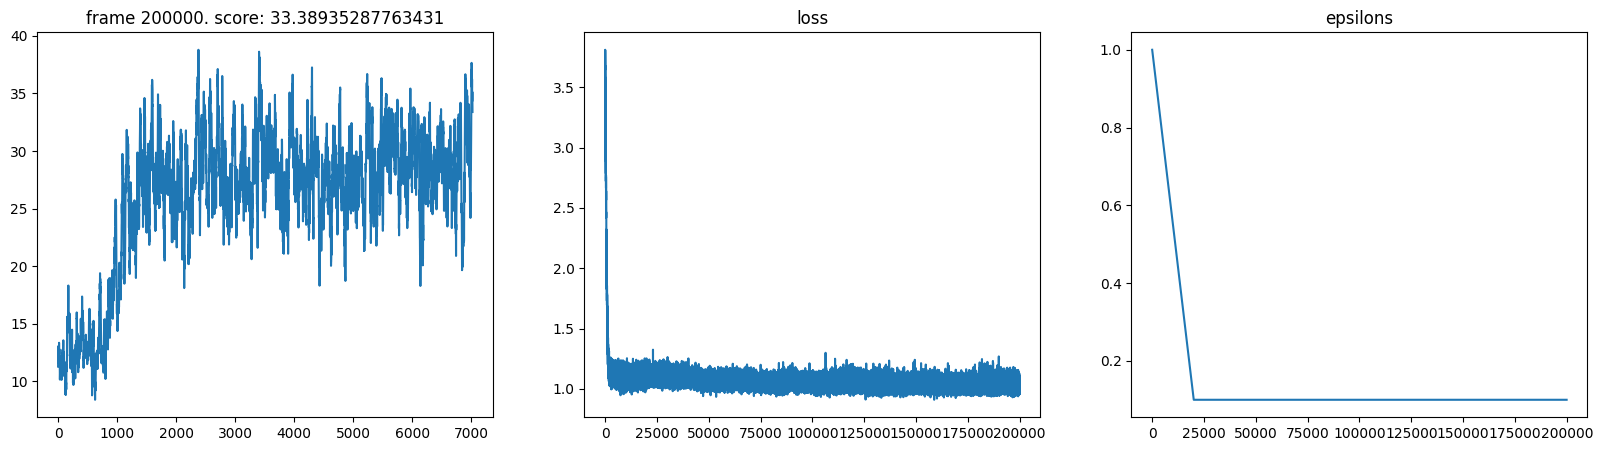

In [8]:
scores, losses, epsilons = agent.train(num_frames)

In [9]:
# pd.DataFrame({"Distributional DQN": scores}).to_csv("../results/distributional_dqn.csv")

# Test the agent

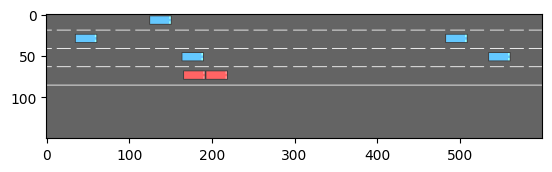

In [10]:
ep_lens, ep_rews = agent.test(1, time_interval=0.01)

In [11]:
print("Mean Episode Length:", np.mean(ep_lens))
print("Mean Score Per Episode:", np.mean(ep_rews))

Mean Episode Length: 22.0
Mean Score Per Episode: 21.10772345392478


# Film the agent

In [14]:
from gymnasium.wrappers import RecordVideo
from agents import BaseDQNAgent

In [15]:
env = gym.make("highway-v0", render_mode="rgb_array")

In [16]:
def film(env: gym.Env, test_agent: BaseDQNAgent, film_length: int, video_folder: str):
    vid_env = RecordVideo(env, video_folder=video_folder,
              episode_trigger=lambda e: True)  # record all episodes

    # Provide the video recorder to the wrapped environment
    # so it can send it intermediate simulation frames.
    vid_env.unwrapped.set_record_video_wrapper(vid_env)

    test_agent.set_mode(is_test=True)

    for i in range(film_length):
        obs, info = vid_env.reset()
        done = truncated = False

        while not (done or truncated):
            action = test_agent.predict(obs, determinstic=True)
            obs, reward, done, truncated, info = vid_env.step(action)
            vid_env.render()
        vid_env.close()

## Before Training

In [17]:
untrained_agent = CategoricalDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma=gamma,
)

film(env, untrained_agent, 10, "../videos/categorical_dqn/untrained/")

cuda
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-0.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-1.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-2.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-3.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-4.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-5.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-6.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-7.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-8.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/untrained/rl-video-episode-9.mp4


## After training

In [18]:
film(env, agent, 10, "../videos/categorical_dqn/trained/")

Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-0.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-1.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-2.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-3.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-4.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-5.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-6.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-7.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-8.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/categorical_dqn/trained/rl-video-episode-9.mp4
